In [2]:
import os
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker import get_execution_role
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session
sagemaker_session = sagemaker.Session()
role = get_execution_role()
my_region = sagemaker_session.boto_session.region_name
import statsmodels.formula.api as smf

In [3]:
my_region

'ap-south-1'

In [4]:
training_data_uri = 'Latest_CV_DATA(2) (3).csv'.format(my_region)

In [5]:
training_data_uri

'Latest_CV_DATA(2) (3).csv'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.float_format', lambda x: '%0.3f' % x)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("Latest_CV_DATA(2) (3).csv",encoding='latin-1')

In [8]:
df.head()

,SRNO,UNIQUESERIALNO,SOLD_DATE,MAKEYEAR,Make_Clean,CLEANEDModel,CLEANEDVariant,CLEANEDfueltype,mixmmvfuelcleaned,BODYTYPE,SUBBODYTYPE,CLEANEDWHEEL,CLEANEDGVW/SEATING CAPACITY,SOLDAMOUNT,STATE_MAPPED,VEHICLENO,METERREADING,UCR,SHROTCOND_MAPPED,INSDT,TAX,PERMIT_MAPPED,SELLERCORPORATENAME,SELLERID,SELLERNAME,KEYREFNUMBER,INV_H_RC_STATUS_CLEANED_MAPPED,Vehicle_Codition,SELLER SEGMENT,Meter_Reading
0,1,S20091800155,26-11-2020,2013,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,445000,Gujarat,GJ16Z6727,246368,20%,FAIR,Live : 28/02/2021,Expired : 30/09/2019,NOT AVAILABLE,a9,AP000337591,JAYESHBHAI ZAVERBHAI PATEL,BHARUO608090001,ORIGINAL RC,MOVABLE,RETAIL,490620.000
1,2,S21092900303,09-11-2021,2010,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,315000,TamilNadu,TN22BT4664,NaN,0.2,FAIR,Live : 29/03/2022,Expired : 31/03/2021,NOT AVAILABLE,a9,AC000156811,CHINNAVELLAI CHINNAVELLAI,ARUPKT908140010,Original RC,IMMOVABLE,Insurance,736100.000
2,3,MKTCV1,01-01-2022,2005,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,231646,Madhya Pradesh,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1112310.000
3,4,MKTCV2,01-01-2021,2005,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,243837,Bihar,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1050260.000
4,5,MKTCV3,01-01-2022,2006,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,243837,Haryana,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1050260.000


In [9]:
df.shape

(403890, 30)

In [10]:
df.describe()

,SRNO,MAKEYEAR,SOLDAMOUNT,Meter_Reading
count,403890.000,403890.000,403890.000,403867.000
mean,189375.979,2010.978,381405.631,349146.631
std,111435.326,14.693,513702.556,305155.394
min,1.000,0.000,33.000,3040.000
25%,90500.000,2008.000,95000.000,133700.000
50%,185353.500,2011.000,185000.000,229950.000
75%,286325.750,2015.000,441055.000,491470.000
max,387298.000,2022.000,9728000.000,2862120.000


In [11]:
df['Make_Clean'].unique()

array(['AMW', 'ASHOKLEYLAND', 'ASHOK LEYLAND', 'BAJAJTEMPO', 'BHARATBENZ',
       'DECANAUTO', 'EICHER', 'Eicher', 'FORCE', 'FORCEMAN', 'Force',
       'FUEL', 'HINDUSTAN', 'ICML', 'MAHINDRA', 'Mahindra', 'MARUTI',
       'MARUTISUZUKI', 'MITSUBISHI', 'PIAGGIO', 'PREMIER', 'SCANIA',
       'SMLISUZU', 'SWARAJMAZDA', 'TATA', 'TOYOTA', 'TRATEC', 'URAL',
       'VOLVO'], dtype=object)

In [12]:
df['Make_Clean'].replace({'ASHOK LEYLAND':'ASHOKLEYLAND'},inplace = True)

In [13]:
df['Make_Clean'].unique()

array(['AMW', 'ASHOKLEYLAND', 'BAJAJTEMPO', 'BHARATBENZ', 'DECANAUTO',
       'EICHER', 'Eicher', 'FORCE', 'FORCEMAN', 'Force', 'FUEL',
       'HINDUSTAN', 'ICML', 'MAHINDRA', 'Mahindra', 'MARUTI',
       'MARUTISUZUKI', 'MITSUBISHI', 'PIAGGIO', 'PREMIER', 'SCANIA',
       'SMLISUZU', 'SWARAJMAZDA', 'TATA', 'TOYOTA', 'TRATEC', 'URAL',
       'VOLVO'], dtype=object)

In [164]:
df['STATE_MAPPED'].value_counts()

TamilNadu                 69602
Andhra Pradesh            69350
Karnataka                 38034
Maharashtra               23227
UttarPradesh              19787
Chandigarh                12064
Gujarat                   11929
Rajasthan                 11883
Madhya Pradesh            11655
Kerala                    10798
WestBengal                 9037
Haryana                    8127
Himachal Pradesh           5762
Jharkhand                  5605
ODISHA                     5278
Bihar                      5205
Assam                      5143
Puducherry                 5081
Delhi                      4516
Jammu & Kashmir            4326
Punjab                     4247
Uttarakhand                4011
Nagaland                   3717
Goa                        3545
Tripura                    3493
Dadar And Nagar Haveli     3492
Mizoram                    3419
Arunachal Pradesh          3419
Sikkim                     3417
Meghalaya                  3411
Telangana                  3409
Lakshadw

In [165]:
df['SELLER SEGMENT'].value_counts()

Insurance    142444
RETAIL       130957
OEM           73604
Leasing       40274
BANK&NBFC     16611
Name: SELLER SEGMENT, dtype: int64

In [166]:
data=df.copy()

In [167]:
data.shape

(403890, 30)

In [168]:
def uppper(df,col):
    df[col]=df[col].str.upper()
    df[col]=df[col].str.replace(' ','')
    return df[col]

In [169]:
def encoding(data,col,col_1,model):
    print(model.head())
    temp = pd.read_csv(data+'.csv',encoding='CP1252')
    temp[col]=uppper(temp,col)
    model_temp = pd.DataFrame()
    labels_temp_map = dict(zip(temp[col],temp['Id (Encoding)']))
    model_temp[col_1] = model[col_1].map(labels_temp_map)
    print(model.head())
    return model_temp[col_1]

In [170]:
def df_reset(df):
    return pd.DataFrame()

In [171]:
data.rename(columns={'CLEANEDMake':'Make_Clean'},inplace=True)
data.rename(columns={'CLEANEDModel':'Model_Clean'},inplace=True)
data.rename(columns={'CLEANEDVariant':'Variant_Clean'},inplace=True)

In [172]:
data.rename(columns={'CLEANEDfueltype':'Fuel_Clean'},inplace=True)
data.rename(columns={'STATE_MAPPED':'CV_State_Clean'},inplace=True)
data.rename(columns={'MAKEYEAR':'MAKE_YEAR'},inplace=True)

In [173]:
data['Make_Clean']=uppper(data,'Make_Clean')
data['Model_Clean']=uppper(data,'Model_Clean')
data['Variant_Clean']=uppper(data,'Variant_Clean')
data['Fuel_Clean']=uppper(data,'Fuel_Clean')
data['CV_State_Clean']=uppper(data,'CV_State_Clean')

In [174]:
data.isnull().sum()

SRNO                                   0
UNIQUESERIALNO                         0
SOLD_DATE                              0
MAKE_YEAR                              0
Make_Clean                             0
Model_Clean                            0
Variant_Clean                          0
Fuel_Clean                             0
mixmmvfuelcleaned                      0
BODYTYPE                               0
SUBBODYTYPE                            0
CLEANEDWHEEL                           0
CLEANEDGVW/SEATING CAPACITY           10
SOLDAMOUNT                             0
CV_State_Clean                         0
VEHICLENO                         113878
METERREADING                      291934
UCR                               115772
SHROTCOND_MAPPED                       4
INSDT                                591
TAX                                   85
PERMIT_MAPPED                      10636
SELLERCORPORATENAME               173054
SELLERID                          113883
SELLERNAME      

In [175]:
data['MMV']= data['Make_Clean']+'_'+data['Model_Clean']+'_'+data['Variant_Clean']

In [176]:
df_1= data.copy()

In [177]:
df_1.shape

(403890, 31)

In [178]:
df_1['SOLDAMOUNT'].min()

33

In [179]:
df_1['SOLDAMOUNT'].max()

9728000

In [180]:
df_3 = df_1[df_1['MMV'].map(df_1['MMV'].value_counts()) >=10]

In [181]:
df_3.shape

(403631, 31)

In [182]:
df_4 = df_3[df_3['MAKE_YEAR']>=2005]

In [183]:
df_4.shape

(372622, 31)

In [184]:
df_4.head()

,SRNO,UNIQUESERIALNO,SOLD_DATE,MAKE_YEAR,Make_Clean,Model_Clean,Variant_Clean,Fuel_Clean,mixmmvfuelcleaned,BODYTYPE,SUBBODYTYPE,CLEANEDWHEEL,CLEANEDGVW/SEATING CAPACITY,SOLDAMOUNT,CV_State_Clean,VEHICLENO,METERREADING,UCR,SHROTCOND_MAPPED,INSDT,TAX,PERMIT_MAPPED,SELLERCORPORATENAME,SELLERID,SELLERNAME,KEYREFNUMBER,INV_H_RC_STATUS_CLEANED_MAPPED,Vehicle_Codition,SELLER SEGMENT,Meter_Reading,MMV
0,1,S20091800155,26-11-2020,2013,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,445000,GUJARAT,GJ16Z6727,246368,20%,FAIR,Live : 28/02/2021,Expired : 30/09/2019,NOT AVAILABLE,a9,AP000337591,JAYESHBHAI ZAVERBHAI PATEL,BHARUO608090001,ORIGINAL RC,MOVABLE,RETAIL,490620.000,AMW_2516HL_6X2CARGOTRUCK
1,2,S21092900303,09-11-2021,2010,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,315000,TAMILNADU,TN22BT4664,NaN,0.2,FAIR,Live : 29/03/2022,Expired : 31/03/2021,NOT AVAILABLE,a9,AC000156811,CHINNAVELLAI CHINNAVELLAI,ARUPKT908140010,Original RC,IMMOVABLE,Insurance,736100.000,AMW_2516HL_6X2CARGOTRUCK
2,3,MKTCV1,01-01-2022,2005,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,231646,MADHYAPRADESH,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1112310.000,AMW_2516HL_6X2CARGOTRUCK
3,4,MKTCV2,01-01-2021,2005,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,243837,BIHAR,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1050260.000,AMW_2516HL_6X2CARGOTRUCK
4,5,MKTCV3,01-01-2022,2006,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,243837,HARYANA,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1050260.000,AMW_2516HL_6X2CARGOTRUCK


In [185]:
df_4.SOLD_DATE=pd.to_datetime(df_4.SOLD_DATE)

In [186]:
df_4["Year_sell"] = df_4.SOLD_DATE.dt.year

In [187]:
df_4["Sell_Month"] = df_4.SOLD_DATE.dt.month

In [188]:
df_4["Sell_Day"] = df_4.SOLD_DATE.dt.day

In [189]:
df_4["CV_Age"] = df_4["Year_sell"] - df_4['MAKE_YEAR']

In [190]:
df_5 = df_4[df_4["CV_Age"]>=0]

In [191]:
df_5

,SRNO,UNIQUESERIALNO,SOLD_DATE,MAKE_YEAR,Make_Clean,Model_Clean,Variant_Clean,Fuel_Clean,mixmmvfuelcleaned,BODYTYPE,SUBBODYTYPE,CLEANEDWHEEL,CLEANEDGVW/SEATING CAPACITY,SOLDAMOUNT,CV_State_Clean,VEHICLENO,METERREADING,UCR,SHROTCOND_MAPPED,INSDT,TAX,PERMIT_MAPPED,SELLERCORPORATENAME,SELLERID,SELLERNAME,KEYREFNUMBER,INV_H_RC_STATUS_CLEANED_MAPPED,Vehicle_Codition,SELLER SEGMENT,Meter_Reading,MMV,Year_sell,Sell_Month,Sell_Day,CV_Age
0,1,S20091800155,2020-11-26,2013,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,445000,GUJARAT,GJ16Z6727,246368,20%,FAIR,Live : 28/02/2021,Expired : 30/09/2019,NOT AVAILABLE,a9,AP000337591,JAYESHBHAI ZAVERBHAI PATEL,BHARUO608090001,ORIGINAL RC,MOVABLE,RETAIL,490620.000,AMW_2516HL_6X2CARGOTRUCK,2020,11,26,7
1,2,S21092900303,2021-09-11,2010,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,315000,TAMILNADU,TN22BT4664,NaN,0.2,FAIR,Live : 29/03/2022,Expired : 31/03/2021,NOT AVAILABLE,a9,AC000156811,CHINNAVELLAI CHINNAVELLAI,ARUPKT908140010,Original RC,IMMOVABLE,Insurance,736100.000,AMW_2516HL_6X2CARGOTRUCK,2021,9,11,11
2,3,MKTCV1,2022-01-01,2005,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,231646,MADHYAPRADESH,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1112310.000,AMW_2516HL_6X2CARGOTRUCK,2022,1,1,17
3,4,MKTCV2,2021-01-01,2005,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,243837,BIHAR,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1050260.000,AMW_2516HL_6X2CARGOTRUCK,2021,1,1,16
4,5,MKTCV3,2022-01-01,2006,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,243837,HARYANA,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1050260.000,AMW_2516HL_6X2CARGOTRUCK,2022,1,1,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403885,387294,MKTCV113870,2021-01-01,2020,VOLVO,FM440,6X4TRUCKTRACTOR,DIESEL,VOLVOFM4406X4TRUCKTRACTORDIESEL,TRACTOR TRAILER,22 WHEELS SEMI TRAILER- 10WHEELS DRIVE TRACTOR...,22,125000,6923303,KERALA,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,Leasing,119000.000,VOLVO_FM440_6X4TRUCKTRACTOR,2021,1,1,1
403886,387295,MKTCV113871,2020-01-01,2020,VOLVO,FM440,6X4TRUCKTRACTOR,DIESEL,VOLVOFM4406X4TRUCKTRACTORDIESEL,TRACTOR TRAILER,22 WHEELS SEMI TRAILER- 10WHEELS DRIVE TRACTOR...,22,125000,7287688,TRIPURA,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,Leasing,56950.000,VOLVO_FM440_6X4TRUCKTRACTOR,2020,1,1,0
403887,387296,MKTCV113872,2022-01-01,2021,VOLVO,FM440,6X4TRUCKTRACTOR,DIESEL,VOLVOFM4406X4TRUCKTRACTORDIESEL,TRACTOR TRAILER,22 WHEELS SEMI TRAILER- 10WHEELS DRIVE TRACTOR...,22,125000,7287688,UTTARPRADESH,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,Leasing,118830.000,VOLVO_FM440_6X4TRUCKTRACTOR,2022,1,1,1
403888,387297,MKTCV113873,2021-01-01,2021,VOLVO,FM440,6X4TRUCKTRACTOR,DIESEL,VOLVOFM4406X4TRUCKTRACTORDIESEL,TRACTOR TRAILER,22 WHEELS SEMI TRAILER- 10WHEELS DRIVE TRACTOR...,22,125000,7671250,GUJARAT,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,Leasing,56780.000,VOLVO_FM440_6X4TRUCKTRACTOR,2021,1,1,0


In [192]:
df_5['MAKE_YEAR'].max()

2022

In [193]:
df_5.shape

(372456, 35)

In [194]:
df_5.columns

Index(['SRNO', 'UNIQUESERIALNO', 'SOLD_DATE', 'MAKE_YEAR', 'Make_Clean',
       'Model_Clean', 'Variant_Clean', 'Fuel_Clean', 'mixmmvfuelcleaned',
       'BODYTYPE', 'SUBBODYTYPE', 'CLEANEDWHEEL',
       'CLEANEDGVW/SEATING CAPACITY', 'SOLDAMOUNT', 'CV_State_Clean',
       'VEHICLENO', 'METERREADING', 'UCR', 'SHROTCOND_MAPPED', 'INSDT', 'TAX',
       'PERMIT_MAPPED', 'SELLERCORPORATENAME', 'SELLERID', 'SELLERNAME',
       'KEYREFNUMBER', 'INV_H_RC_STATUS_CLEANED_MAPPED', 'Vehicle_Codition',
       'SELLER SEGMENT', 'Meter_Reading', 'MMV', 'Year_sell', 'Sell_Month',
       'Sell_Day', 'CV_Age'],
      dtype='object')

In [195]:
df_5['Meter_Reading'].describe()

count    372435.000
mean     294762.411
std      231579.190
min        3240.000
25%      126070.000
50%      209860.000
75%      402050.000
max     1112310.000
Name: Meter_Reading, dtype: float64

In [196]:
df_5.isnull().sum()/len(df_5)

SRNO                             0.000
UNIQUESERIALNO                   0.000
SOLD_DATE                        0.000
MAKE_YEAR                        0.000
Make_Clean                       0.000
Model_Clean                      0.000
Variant_Clean                    0.000
Fuel_Clean                       0.000
mixmmvfuelcleaned                0.000
BODYTYPE                         0.000
SUBBODYTYPE                      0.000
CLEANEDWHEEL                     0.000
CLEANEDGVW/SEATING CAPACITY      0.000
SOLDAMOUNT                       0.000
CV_State_Clean                   0.000
VEHICLENO                        0.284
METERREADING                     0.720
UCR                              0.279
SHROTCOND_MAPPED                 0.000
INSDT                            0.001
TAX                              0.000
PERMIT_MAPPED                    0.026
SELLERCORPORATENAME              0.438
SELLERID                         0.284
SELLERNAME                       0.284
KEYREFNUMBER             

In [197]:
df_5.columns=[c.replace(" ","_")for c in df_5.columns]

In [198]:
df_5['Meter_Reading'].min()

3240.0

In [199]:
df_5['SOLDAMOUNT'].max()

9728000

In [200]:
df_5['SOLDAMOUNT'].min()

500

In [201]:
pct_null = df_5.isnull().sum() / len(df_5)
missing_features = pct_null[pct_null > 0.70].index
# df.drop(missing_features, axis=1, inplace=True)

In [202]:
missing_features

Index(['METERREADING'], dtype='object')

In [203]:
inp1=df_5.select_dtypes(exclude='object')

In [204]:
inp1.shape

(372456, 9)

In [205]:
inp1

,SRNO,SOLD_DATE,MAKE_YEAR,SOLDAMOUNT,Meter_Reading,Year_sell,Sell_Month,Sell_Day,CV_Age
0,1,2020-11-26,2013,445000,490620.000,2020,11,26,7
1,2,2021-09-11,2010,315000,736100.000,2021,9,11,11
2,3,2022-01-01,2005,231646,1112310.000,2022,1,1,17
3,4,2021-01-01,2005,243837,1050260.000,2021,1,1,16
4,5,2022-01-01,2006,243837,1050260.000,2022,1,1,16
...,...,...,...,...,...,...,...,...,...
403885,387294,2021-01-01,2020,6923303,119000.000,2021,1,1,1
403886,387295,2020-01-01,2020,7287688,56950.000,2020,1,1,0
403887,387296,2022-01-01,2021,7287688,118830.000,2022,1,1,1
403888,387297,2021-01-01,2021,7671250,56780.000,2021,1,1,0


In [206]:
#from scipy.stats import gaussian_kde
#fig = plt.figure(figsize=(18,5))
#
#
#for i,b in enumerate(list(inp1.columns)):
#    
#    i +=1
#    ax = fig.add_subplot(1,13,i)
#    sns.kdeplot(inp1[b])
#
#    ax.set_title(b)
#
#sns.set_style("whitegrid")
#plt.tight_layout()
#plt.legend()
#plt.show()

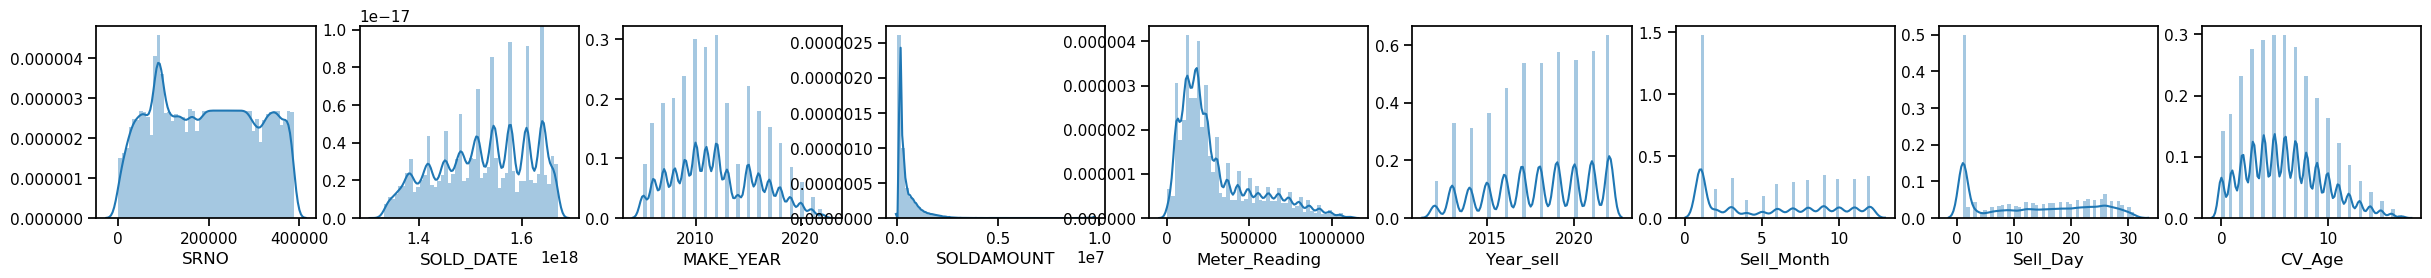

In [207]:
plt.subplots(figsize=(30,15))
 
for i, col in enumerate(inp1):
  plt.subplot(3,9,i+1)
  sns.distplot(inp1[col])
plt.subplots_adjust(hspace=1.5) 
plt.show()

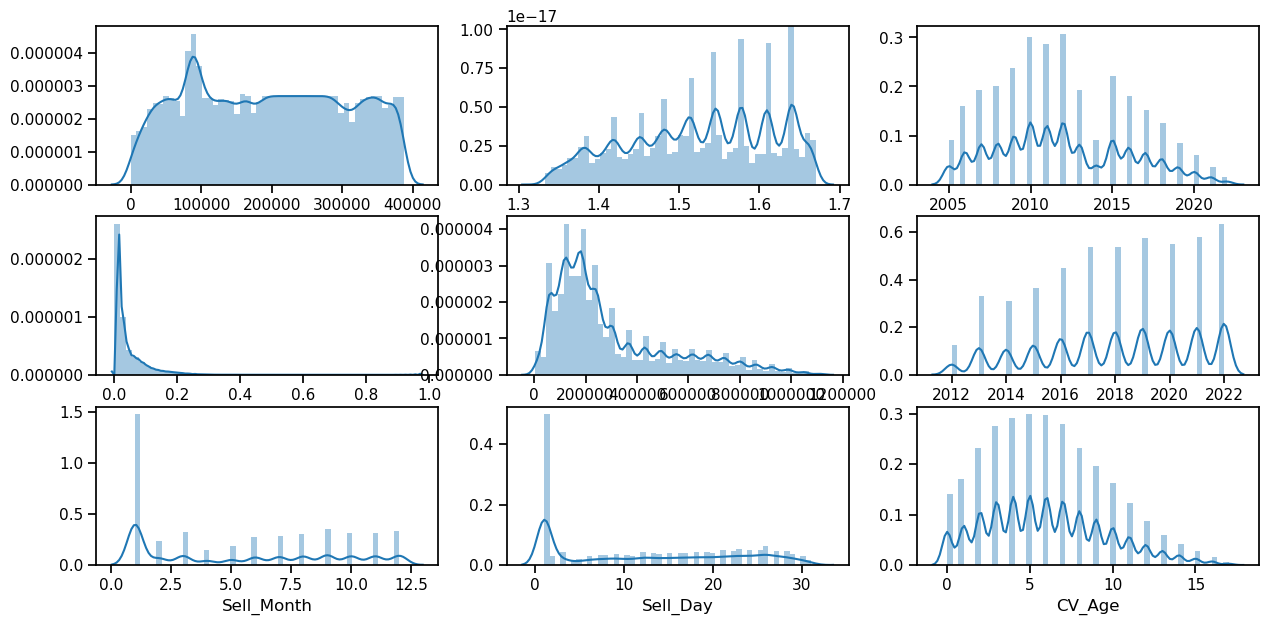

In [208]:
plt.subplots(figsize=(15,7))
 
for i, col in enumerate(inp1):
  plt.subplot(3,3,i+1)
  sns.distplot(inp1[col])
plt.show()

In [209]:
#features = ['MAKE_YEAR', 'Make_Clean', 'Model_Clean', 'Variant_Clean', 'Fuel_Clean', 'CV_State_Clean', 'SELLER_SEGMENT']
#
#for feature in features:
#    grouped_data = highly_wrong_predictions.groupby(feature).agg({'Actual': 'mean', 'Predicted': 'mean'})
#    grouped_data.plot(kind='bar', figsize=(10, 6))

In [210]:

#fig, axes = plt.subplots(nrows=3, ncols=9, figsize=(30, 15))
#
#for i, col in enumerate(inp1):
#    ax = axes[i // 9, i % 9]  # Get the appropriate subplot axes
#    sns.distplot(inp1[col], ax=ax)
#    ax.set_title(col)  # Set the title for each subplot
#
#plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots
#plt.show()

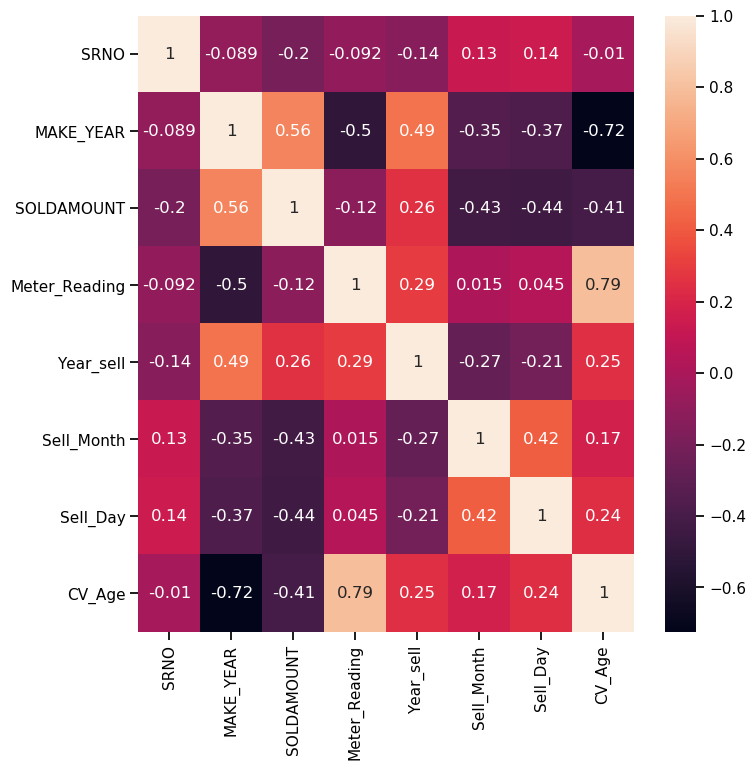

In [211]:
# Let's see the correlation matrix 
plt.figure(figsize = (8,8))        # Size of the figure
sns.heatmap(inp1.corr(),annot = True)
plt.show()

In [212]:
df_5.shape

(372456, 35)

In [213]:
df_5.head()

,SRNO,UNIQUESERIALNO,SOLD_DATE,MAKE_YEAR,Make_Clean,Model_Clean,Variant_Clean,Fuel_Clean,mixmmvfuelcleaned,BODYTYPE,SUBBODYTYPE,CLEANEDWHEEL,CLEANEDGVW/SEATING_CAPACITY,SOLDAMOUNT,CV_State_Clean,VEHICLENO,METERREADING,UCR,SHROTCOND_MAPPED,INSDT,TAX,PERMIT_MAPPED,SELLERCORPORATENAME,SELLERID,SELLERNAME,KEYREFNUMBER,INV_H_RC_STATUS_CLEANED_MAPPED,Vehicle_Codition,SELLER_SEGMENT,Meter_Reading,MMV,Year_sell,Sell_Month,Sell_Day,CV_Age
0,1,S20091800155,2020-11-26,2013,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,445000,GUJARAT,GJ16Z6727,246368,20%,FAIR,Live : 28/02/2021,Expired : 30/09/2019,NOT AVAILABLE,a9,AP000337591,JAYESHBHAI ZAVERBHAI PATEL,BHARUO608090001,ORIGINAL RC,MOVABLE,RETAIL,490620.000,AMW_2516HL_6X2CARGOTRUCK,2020,11,26,7
1,2,S21092900303,2021-09-11,2010,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,315000,TAMILNADU,TN22BT4664,NaN,0.2,FAIR,Live : 29/03/2022,Expired : 31/03/2021,NOT AVAILABLE,a9,AC000156811,CHINNAVELLAI CHINNAVELLAI,ARUPKT908140010,Original RC,IMMOVABLE,Insurance,736100.000,AMW_2516HL_6X2CARGOTRUCK,2021,9,11,11
2,3,MKTCV1,2022-01-01,2005,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,231646,MADHYAPRADESH,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1112310.000,AMW_2516HL_6X2CARGOTRUCK,2022,1,1,17
3,4,MKTCV2,2021-01-01,2005,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,243837,BIHAR,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1050260.000,AMW_2516HL_6X2CARGOTRUCK,2021,1,1,16
4,5,MKTCV3,2022-01-01,2006,AMW,2516HL,6X2CARGOTRUCK,DIESEL,AMW2516HL6X2CARGOTRUCKDIESEL,HAULAGE TRUCK,10 WHEELS / GVW 25000KG TO 28500KG /RIGID BODY,10,25000,243837,HARYANA,NaN,NaN,40-50%,GOOD,LIVE,VALID,VALID,NaN,NaN,NaN,NaN,ORIGINAL RC,MOVABLE,OEM,1050260.000,AMW_2516HL_6X2CARGOTRUCK,2022,1,1,16


In [214]:
df_5.columns

Index(['SRNO', 'UNIQUESERIALNO', 'SOLD_DATE', 'MAKE_YEAR', 'Make_Clean',
       'Model_Clean', 'Variant_Clean', 'Fuel_Clean', 'mixmmvfuelcleaned',
       'BODYTYPE', 'SUBBODYTYPE', 'CLEANEDWHEEL',
       'CLEANEDGVW/SEATING_CAPACITY', 'SOLDAMOUNT', 'CV_State_Clean',
       'VEHICLENO', 'METERREADING', 'UCR', 'SHROTCOND_MAPPED', 'INSDT', 'TAX',
       'PERMIT_MAPPED', 'SELLERCORPORATENAME', 'SELLERID', 'SELLERNAME',
       'KEYREFNUMBER', 'INV_H_RC_STATUS_CLEANED_MAPPED', 'Vehicle_Codition',
       'SELLER_SEGMENT', 'Meter_Reading', 'MMV', 'Year_sell', 'Sell_Month',
       'Sell_Day', 'CV_Age'],
      dtype='object')

In [215]:
columns=['SOLD_DATE', 'MAKE_YEAR', 'Make_Clean',
       'Model_Clean', 'Variant_Clean', 'Fuel_Clean', 'mixmmvfuelcleaned',
       'BODYTYPE', 'SUBBODYTYPE', 'CLEANEDWHEEL',
       'CLEANEDGVW/SEATING_CAPACITY', 'SOLDAMOUNT', 'CV_State_Clean',
       'VEHICLENO', 'METERREADING', 'UCR', 'SHROTCOND_MAPPED', 'INSDT', 'TAX',
       'PERMIT_MAPPED', 'SELLERCORPORATENAME', 'SELLERID', 'SELLERNAME',
       'KEYREFNUMBER', 'INV_H_RC_STATUS_CLEANED_MAPPED', 'Vehicle_Codition',
       'SELLER_SEGMENT', 'Meter_Reading', 'MMV', 'Year_sell', 'Sell_Month',
       'Sell_Day', 'CV_Age']

In [216]:
df_5.reset_index(drop=True,inplace =True)

In [217]:
Model_data = df_5.copy()

In [218]:
Model_data.shape

(372456, 35)

In [219]:
#Model_data.to_csv('Model_data_final_CV_CS_NEW_.csv')

In [220]:
cat_f=Model_data.select_dtypes(include='object').columns

In [221]:
cat_f

Index(['UNIQUESERIALNO', 'Make_Clean', 'Model_Clean', 'Variant_Clean',
       'Fuel_Clean', 'mixmmvfuelcleaned', 'BODYTYPE', 'SUBBODYTYPE',
       'CLEANEDWHEEL', 'CLEANEDGVW/SEATING_CAPACITY', 'CV_State_Clean',
       'VEHICLENO', 'METERREADING', 'UCR', 'SHROTCOND_MAPPED', 'INSDT', 'TAX',
       'PERMIT_MAPPED', 'SELLERCORPORATENAME', 'SELLERID', 'SELLERNAME',
       'KEYREFNUMBER', 'INV_H_RC_STATUS_CLEANED_MAPPED', 'Vehicle_Codition',
       'SELLER_SEGMENT', 'MMV'],
      dtype='object')

In [222]:
cat_f=['SOLD_DATE', 'MAKE_YEAR', 'Make_Clean',
       'Model_Clean', 'Variant_Clean', 'Fuel_Clean', 'mixmmvfuelcleaned',
       'BODYTYPE', 'SUBBODYTYPE', 'CLEANEDWHEEL',
       'CLEANEDGVW/SEATING_CAPACITY', 'SOLDAMOUNT', 'CV_State_Clean',
       'VEHICLENO', 'METERREADING', 'UCR', 'SHROTCOND_MAPPED', 'INSDT', 'TAX',
       'PERMIT_MAPPED', 'SELLERCORPORATENAME', 'SELLERID', 'SELLERNAME',
       'KEYREFNUMBER', 'INV_H_RC_STATUS_CLEANED_MAPPED', 'Vehicle_Codition',
       'SELLER_SEGMENT', 'Meter_Reading', 'MMV', 'Year_sell', 'Sell_Month',
       'Sell_Day', 'CV_Age']

In [223]:
num_f=Model_data.select_dtypes(exclude='object').columns

In [224]:
num_f

Index(['SRNO', 'SOLD_DATE', 'MAKE_YEAR', 'SOLDAMOUNT', 'Meter_Reading',
       'Year_sell', 'Sell_Month', 'Sell_Day', 'CV_Age'],
      dtype='object')

In [225]:
inp1=Model_data.select_dtypes(exclude='object')

In [226]:
columns=Model_data.select_dtypes(exclude='object').columns

In [227]:
columns

Index(['SRNO', 'SOLD_DATE', 'MAKE_YEAR', 'SOLDAMOUNT', 'Meter_Reading',
       'Year_sell', 'Sell_Month', 'Sell_Day', 'CV_Age'],
      dtype='object')

In [228]:
inp_cat=Model_data.select_dtypes(include='object')

In [229]:
inp_cat.columns

Index(['UNIQUESERIALNO', 'Make_Clean', 'Model_Clean', 'Variant_Clean',
       'Fuel_Clean', 'mixmmvfuelcleaned', 'BODYTYPE', 'SUBBODYTYPE',
       'CLEANEDWHEEL', 'CLEANEDGVW/SEATING_CAPACITY', 'CV_State_Clean',
       'VEHICLENO', 'METERREADING', 'UCR', 'SHROTCOND_MAPPED', 'INSDT', 'TAX',
       'PERMIT_MAPPED', 'SELLERCORPORATENAME', 'SELLERID', 'SELLERNAME',
       'KEYREFNUMBER', 'INV_H_RC_STATUS_CLEANED_MAPPED', 'Vehicle_Codition',
       'SELLER_SEGMENT', 'MMV'],
      dtype='object')

In [230]:
Model_data.fillna(Model_data.select_dtypes(include='number').median().iloc[0], inplace=True)

In [231]:
Model_data.fillna(Model_data.select_dtypes(include='object').mode().iloc[0], inplace=True)

In [232]:
Model_data_= Model_data[['MAKE_YEAR','Make_Clean','Model_Clean','Variant_Clean','Fuel_Clean','CV_State_Clean','SELLER_SEGMENT','Meter_Reading','SOLDAMOUNT','Year_sell']]

In [233]:
Model_data_.columns

Index(['MAKE_YEAR', 'Make_Clean', 'Model_Clean', 'Variant_Clean', 'Fuel_Clean',
       'CV_State_Clean', 'SELLER_SEGMENT', 'Meter_Reading', 'SOLDAMOUNT',
       'Year_sell'],
      dtype='object')

In [234]:
X=Model_data_.drop(['SOLDAMOUNT'],axis=1)
y=Model_data_[['SOLDAMOUNT']]

In [235]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [236]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [237]:
ohe=OneHotEncoder()
ohe.fit(X[['Make_Clean','Model_Clean','Variant_Clean','Fuel_Clean','CV_State_Clean','SELLER_SEGMENT']])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [238]:
column_trans=make_column_transformer((OneHotEncoder(categories=ohe.categories_),['Make_Clean','Model_Clean','Variant_Clean','Fuel_Clean','CV_State_Clean','SELLER_SEGMENT',]),remainder='passthrough')

In [239]:
column_trans

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('onehotencoder',
                                 OneHotEncoder(categories=[array(['AMW', 'ASHOKLEYLAND', 'BAJAJTEMPO', 'BHARATBENZ', 'DECANAUTO',
       'EICHER', 'FORCE', 'FORCEMAN', 'HINDUSTAN', 'ICML', 'MAHINDRA',
       'MARUTISUZUKI', 'PIAGGIO', 'PREMIER', 'SCANIA', 'SMLISUZU',
       'SWARAJMAZDA',...
       'SECUNDERABAD', 'SIKKIM', 'TAMILNADU', 'TELANGANA', 'TRICHY',
       'TRIPURA', 'UTTARAKHAND', 'UTTARPRADESH', 'VIJAYAWADA', 'WARANGAL',
       'WESTBENGAL'], dtype=object),
                                                           array(['BANK&NBFC', 'Insurance', 'Leasing', 'OEM', 'RETAIL'], dtype=object)],
                                               drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
          

In [240]:
!pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [241]:
from sklearn import model_selection
from xgboost import XGBRegressor

In [242]:
regressor=XGBRegressor(max_depth=8,learning_rate=0.01,
                   n_estimators=5000,
                   #objective='reg:linear',
                   objective='reg:squarederror', 
                   booster='gbtree')

In [243]:
#regressor = XGBRegressor(base_score=0.25, booster='gbtree', colsample_bylevel=1,
#                                 colsample_bytree=0.1, gamma=0, learning_rate=0.1, max_delta_step=0.7,
#                                 max_depth=8, min_child_num_Weight=5, missing=1, n_estimators=500,
#                                 n_jobs=1, nthread=None, objective='reg:squarederror', random_state=707,
#                                 reg_alpha=10, reg_lambda=300, scale_pos_num_Weight=0.1, seed=42,
#                                 silent=True, subsample=0.1)

In [244]:
pipe=make_pipeline(column_trans,regressor)

In [245]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[array(['AMW', 'ASHOKLEYLAND', 'BAJAJTEMPO', 'BHARATBENZ', 'DECANAUTO',
       'EICHER', 'FORCE', 'FORCEMAN', 'HINDUSTAN', 'ICML', 'MAHINDRA',
       'MARUTISUZUKI', 'PIAG...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.01, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=8, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()'

In [246]:
y_pred=pipe.predict(X_test)
y_pred

array([297740.75,  74803.83,  78801.35, ...,  89420.65, 132081.89,
       309105.2 ], dtype=float32)

In [247]:
y_train_pred=pipe.predict(X_train)
y_train_pred

array([ 33918.58, 116720.6 ,  64387.19, ...,  49525.26, 894383.4 ,
       180031.55], dtype=float32)

In [248]:
r2_score(y_train,y_train_pred)

0.954538980347219

In [249]:
r2_score(y_test,y_pred)

0.9517566306207181

In [250]:
import pickle

In [251]:
pickle.dump(pipe,open('FInal_regressor_CV_CS_NEW_.pkl','wb'))

In [252]:
#df_5[67903:67945]

In [253]:
pipe.predict(pd.DataFrame(columns=['MAKE_YEAR','Make_Clean','Model_Clean','Variant_Clean','Fuel_Clean','CV_State_Clean','SELLER_SEGMENT','Meter_Reading','Year_sell'],data=np.array([2012,'BHARATBENZ','4928TT','6X4TRUCKTRACTOR','DIESEL','CHATTISGARH','OEM',300000,2012]).reshape(1,9)))

array([942332.44], dtype=float32)

In [254]:
df_5['CV_State_Clean'].unique()

array(['GUJARAT', 'TAMILNADU', 'MADHYAPRADESH', 'BIHAR', 'HARYANA',
       'PUNJAB', 'ANDHRAPRADESH', 'KERALA', 'TRIPURA', 'UTTARPRADESH',
       'MAHARASHTRA', 'MIZORAM', 'RAJASTHAN', 'WESTBENGAL', 'UTTARAKHAND',
       'ARUNACHALPRADESH', 'HIMACHALPRADESH', 'CHANDIGARH',
       'JAMMU&KASHMIR', 'ODISHA', 'ASSAM', 'KARNATAKA', 'GOA',
       'JHARKHAND', 'DELHI', 'MANIPUR', 'DAMANANDDIU', 'NAGALAND',
       'MEGHALAYA', 'SIKKIM', 'PUDUCHERRY', 'LAKSHADWEEP',
       'DADARANDNAGARHAVELI', 'DELHIANDNCR', 'HUBLI', 'BIHARANDJKD',
       'WARANGAL', 'PUNJABHPANDJK', 'NORTHEAST', 'CHENNAI', 'TELANGANA',
       'NAGPUR', 'VIJAYAWADA', 'KURNOOL', 'TRICHY', 'MANGALORE',
       'COIMBATORE', 'MADURAI', 'BANGALORE', 'HYDERABAD', 'SECUNDERABAD',
       'PUNE', 'MUMBAIANDGOA', 'CHATTISGARH'], dtype=object)

In [255]:
X_train_copy=X_train.copy()

In [256]:
X_train_copy['Predicted']=y_train_pred

In [257]:
X_train_copy['Actual']=y_train

In [258]:
X_train_copy['Predicted']

238237    33918.578
204429   116720.602
166322    64387.191
344213   118136.734
194270   147257.344
            ...    
259178    75800.922
365838   159971.766
131932    49525.262
146867   894383.375
121958   180031.547
Name: Predicted, Length: 297964, dtype: float32

In [259]:
X_train_copy.head(20)

,MAKE_YEAR,Make_Clean,Model_Clean,Variant_Clean,Fuel_Clean,CV_State_Clean,SELLER_SEGMENT,Meter_Reading,Year_sell,Predicted,Actual
238237,2011,TATA,ACE,4X2PICKUP,DIESEL,UTTARPRADESH,Insurance,243390.000,2020,33918.578,20000
204429,2009,TATA,ACE,4X2PICKUP,DIESEL,KARNATAKA,Insurance,152040.000,2014,116720.602,85000
166322,2009,TATA,ACE,4X2PICKUP,DIESEL,MADHYAPRADESH,BANK&NBFC,350840.000,2022,64387.191,90000
344213,2015,TATA,MAGICIRIS,4X2MINIBUS,DIESEL,KERALA,RETAIL,195840.000,2018,118136.734,128500
194270,2013,TATA,ACE,4X2PICKUP,DIESEL,TAMILNADU,RETAIL,142170.000,2018,147257.344,213000
95966,2021,EICHER,PRO2075ECBCPTOABSPSBS6,4X2TANKERTRUCK,DIESEL,CHANDIGARH,OEM,56780.000,2021,1906912.250,2222320
182752,2011,TATA,ACE,4X2PICKUP,DIESEL,ANDHRAPRADESH,Insurance,90580.000,2014,153734.516,159000
236607,2008,TATA,ACE,4X2PICKUP,DIESEL,TAMILNADU,RETAIL,330820.000,2020,58939.086,75000
187146,2006,TATA,ACE,4X2PICKUP,DIESEL,RAJASTHAN,RETAIL,284830.000,2017,52012.250,37000
310983,2017,TATA,LPT3118,8X2CARGOTRUCK,DIESEL,MADHYAPRADESH,RETAIL,217430.000,2020,1354848.750,1640000


In [260]:
MAPE=abs((X_train_copy['Actual']-X_train_copy['Predicted'])/X_train_copy['Actual']).mean()*100

In [261]:
MAPE

41.630560274561326

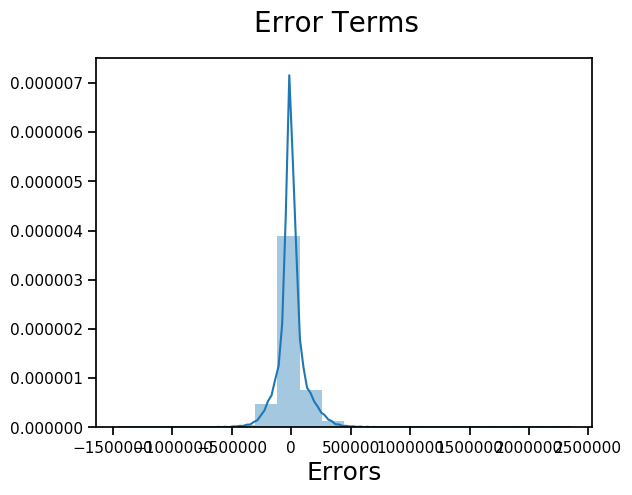

In [262]:
# Plot the histogram of the error terms
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure()
sns.distplot((X_train_copy['Actual'] - X_train_copy['Predicted']), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  
plt.xlabel('Errors', fontsize = 18)  
plt.show()

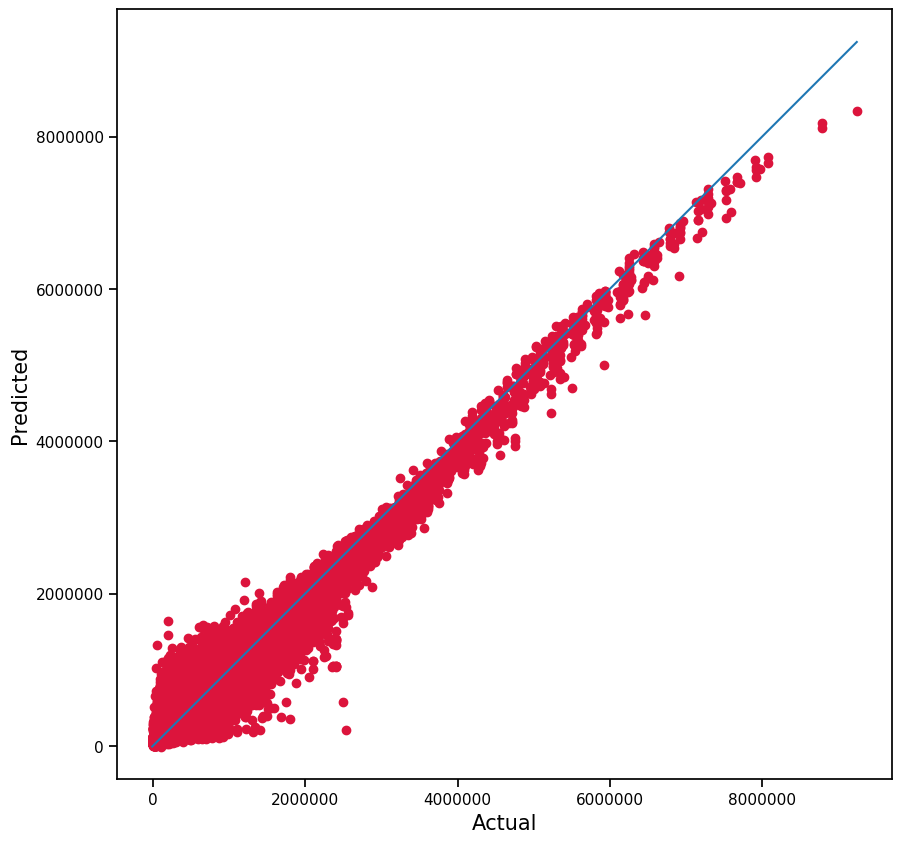

In [263]:
plt.figure(figsize=(10,10))
plt.scatter(X_train_copy['Actual'], X_train_copy['Predicted'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(X_train_copy['Predicted']), max(X_train_copy['Actual']))
p2 = min(min(X_train_copy['Predicted']), min(X_train_copy['Actual']))
plt.plot([p1, p2], [p1, p2])
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axis('equal')
plt.show()

In [264]:
X_test_copy=X_test.copy()
X_test_copy['Predicted']=y_pred
X_test_copy['Actual']=y_test


In [265]:
X_test_copy['Predicted']

291145    297740.750
163225     74803.828
219277     78801.352
203671     92563.922
129159    262767.125
             ...    
26703     250188.312
352561   1814582.875
269576     89420.648
219819    132081.891
19710     309105.188
Name: Predicted, Length: 74492, dtype: float32

In [266]:
X_test_copy.head(10)

,MAKE_YEAR,Make_Clean,Model_Clean,Variant_Clean,Fuel_Clean,CV_State_Clean,SELLER_SEGMENT,Meter_Reading,Year_sell,Predicted,Actual
291145,2007,TATA,LPS4018,4X2COMBINATIONTRUCK,DIESEL,UTTARPRADESH,RETAIL,920380.000,2021,297740.750,160000
163225,2009,TATA,207DI,4X2PICKUP,DIESEL,ANDHRAPRADESH,Insurance,207200.000,2017,74803.828,56000
219277,2007,TATA,ACE,4X2PICKUP,DIESEL,TAMILNADU,RETAIL,191170.000,2014,78801.352,93000
203671,2011,TATA,ACE,4X2PICKUP,DIESEL,KARNATAKA,Insurance,194670.000,2018,92563.922,10000
129159,2017,MAHINDRA,BOLEROPICKUPFBMICROHYBRIDBS3,4X2PICKUP,DIESEL,DELHI,OEM,151200.000,2022,262767.125,282021
31069,2020,ASHOKLEYLAND,ALPSV4/17CHASSIS,4X2BUS,DIESEL,BIHAR,OEM,56950.000,2020,1551361.125,1543275
279619,2012,TATA,ACEZIP,4X2PICKUP,DIESEL,KERALA,Insurance,159040.000,2018,60601.926,10820
6658,2005,ASHOKLEYLAND,1613COMETSUPER,4X2CARGOTRUCK,DIESEL,MAHARASHTRA,RETAIL,837420.000,2018,219301.469,185000
172440,2012,TATA,ACE,4X2PICKUP,DIESEL,ANDHRAPRADESH,Insurance,83580.000,2015,167409.859,234000
298549,2013,TATA,LPT1613,4X2CARGOTRUCK,DIESEL,GUJARAT,Leasing,28910.000,2020,408303.062,331710


In [267]:
vertical_concat = pd.concat([X_train_copy,X_test_copy ], axis=0)

In [268]:
vertical_concat['Diffrence']=vertical_concat['Predicted']-vertical_concat['Actual']

In [269]:
vertical_concat['%_diff']=((vertical_concat['Diffrence']/vertical_concat['Actual'])*100)

In [270]:
vertical_concat

,MAKE_YEAR,Make_Clean,Model_Clean,Variant_Clean,Fuel_Clean,CV_State_Clean,SELLER_SEGMENT,Meter_Reading,Year_sell,Predicted,Actual,Diffrence,%_diff
238237,2011,TATA,ACE,4X2PICKUP,DIESEL,UTTARPRADESH,Insurance,243390.000,2020,33918.578,20000,13918.578,69.593
204429,2009,TATA,ACE,4X2PICKUP,DIESEL,KARNATAKA,Insurance,152040.000,2014,116720.602,85000,31720.602,37.318
166322,2009,TATA,ACE,4X2PICKUP,DIESEL,MADHYAPRADESH,BANK&NBFC,350840.000,2022,64387.191,90000,-25612.809,-28.459
344213,2015,TATA,MAGICIRIS,4X2MINIBUS,DIESEL,KERALA,RETAIL,195840.000,2018,118136.734,128500,-10363.266,-8.065
194270,2013,TATA,ACE,4X2PICKUP,DIESEL,TAMILNADU,RETAIL,142170.000,2018,147257.344,213000,-65742.656,-30.865
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26703,2006,ASHOKLEYLAND,3516,4X2TRUCKTRACTOR,DIESEL,MAHARASHTRA,Insurance,695640.000,2017,250188.312,190000,60188.312,31.678
352561,2018,TATA,SIGNA3718.T,10X2CARGOTRUCK,DIESEL,DADARANDNAGARHAVELI,Leasing,305150.000,2022,1814582.875,1958815,-144232.125,-7.363
269576,2012,TATA,ACEHT,4X2PICKUP,DIESEL,WESTBENGAL,RETAIL,200830.000,2019,89420.648,28000,61420.648,219.359
219819,2012,TATA,ACE,4X2PICKUP,DIESEL,TAMILNADU,RETAIL,152740.000,2017,132081.891,192000,-59918.109,-31.207


In [271]:
#vertical_concat.to_csv('NEW_CV_CS_Actual vs Predicted_.csv')

In [272]:
vertical_concat.describe()

,MAKE_YEAR,Meter_Reading,Year_sell,Predicted,Actual,Diffrence,%_diff
count,372456.000,372456.000,372456.000,372456.000,372456.000,372456.000,372456.000
mean,2011.951,294756.712,2017.953,397539.250,397608.699,-76.970,24.894
std,4.046,231573.905,2.884,499696.062,529244.048,113527.629,130.701
min,2005.000,3240.000,2012.000,-8771.328,500.000,-2326655.938,-159.373
25%,2009.000,126130.000,2016.000,103629.258,95000.000,-41026.234,-14.394
50%,2011.000,209860.000,2018.000,194001.109,190000.000,6475.270,3.543
75%,2015.000,401922.500,2020.000,478049.094,478289.000,46177.445,33.021
max,2022.000,1112310.000,2022.000,8357574.000,9728000.000,1433461.000,16394.191


In [273]:
vertical_concat.isnull().sum()

MAKE_YEAR         0
Make_Clean        0
Model_Clean       0
Variant_Clean     0
Fuel_Clean        0
CV_State_Clean    0
SELLER_SEGMENT    0
Meter_Reading     0
Year_sell         0
Predicted         0
Actual            0
Diffrence         0
%_diff            0
dtype: int64

In [274]:
MAPE_test=abs((X_test_copy['Actual']-X_test_copy['Predicted'])/X_test_copy['Actual']).mean()*100

In [275]:
MAPE_test

42.300815717065575

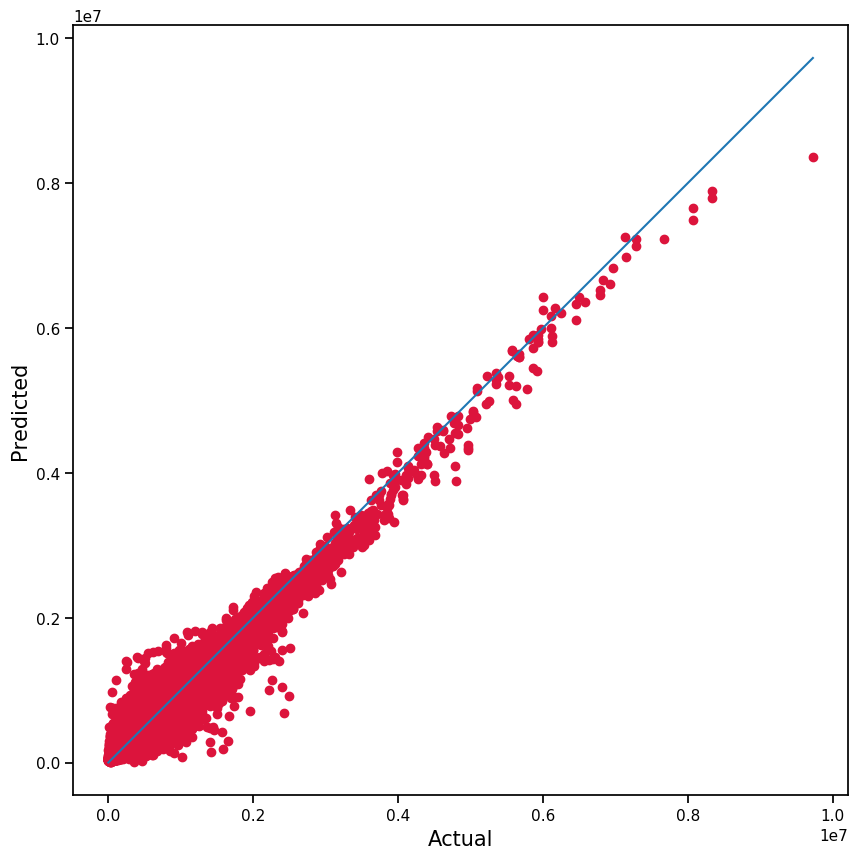

In [276]:
plt.figure(figsize=(10,10))
plt.scatter(X_test_copy['Actual'], X_test_copy['Predicted'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(X_test_copy['Predicted']), max(X_test_copy['Actual']))
p2 = min(min(X_test_copy['Predicted']), min(X_test_copy['Actual']))
plt.plot([p1, p2], [p1, p2])
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axis('equal')
plt.show()

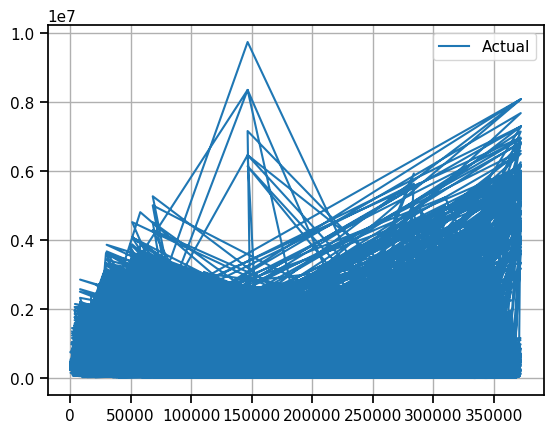

In [277]:
plt.plot(X_test_copy['Actual'],label='Actual')
#plt.plot(X_test_copy['Predicted'],label='Predicted')
plt.legend()
plt.grid()
plt.show()

In [278]:
incorrect = X_test_copy[X_test_copy["Actual"] != X_test_copy["Predicted"]]

In [288]:
X_test_copy['Abs Error'] = abs(X_test_copy['Actual'] - X_test_copy['Predicted'])

# Calculate the percentile rank of the absolute error within the test data set
X_test_copy['Error Rank'] = X_test_copy['Abs Error'].rank(pct=True)

# Select the top 5% of highly wrong predictions
highly_wrong_predictions = X_test_copy[X_test_copy['Error Rank'] >= 0.95]

# Print the highly wrong predictions
#print(highly_wrong_predictions)
highly_wrong_predictions.info

<bound method DataFrame.info of         MAKE_YEAR    Make_Clean                 Model_Clean  \
24794        2015  ASHOKLEYLAND                        3118   
8088         2017  ASHOKLEYLAND                        1618   
7355         2011  ASHOKLEYLAND                        1616   
129974       2019      MAHINDRA              DI3200CRXCABIN   
299542       2006          TATA        LPT1616/42BS3697COWL   
...           ...           ...                         ...   
349067       2020          TATA  SFC407/31WBHTCABCHASSISBS4   
26423        2007  ASHOKLEYLAND                        3516   
29839        2017  ASHOKLEYLAND                        4923   
23140        2012  ASHOKLEYLAND                        3116   
16482        2009  ASHOKLEYLAND                        2214   

                Variant_Clean Fuel_Clean    CV_State_Clean SELLER_SEGMENT  \
24794           8X2CARGOTRUCK     DIESEL      UTTARPRADESH      Insurance   
8088    4X2CONTAINERIZEDTRUCK     DIESEL              PUN

In [282]:
# Identify the indices of highly wrong predictions
wrong_prediction_indices = X_test_copy[X_test_copy['Error Rank'] >= 0.95].index

# Create a new dataframe without the highly wrong predictions
filtered_dataframe = X_test_copy.drop(wrong_prediction_indices)

# Separate the features and target variables from the filtered dataframe
X_filtered = filtered_dataframe.drop(['Actual', 'Predicted', 'Abs Error', 'Error Rank'], axis=1)
y_filtered = filtered_dataframe['Actual']

# Retrain the model on the filtered data
pipe.fit(X_filtered, y_filtered)

# Make predictions using the updated model
new_predictions = pipe.predict(X_test)  # Assuming X_test is the original test data

# Continue with your further analysis or evaluation


In [ ]:
#highly_wrong_predictions.to_csv('highly_wrong_predictions.csv')
r2_score(y_test,new_predictions)
MAPE_new_predictions

In [ ]:
# Analyze actual and predicted values based on each feature
features = ['MAKE_YEAR', 'Make_Clean', 'Model_Clean', 'Variant_Clean', 'Fuel_Clean', 'CV_State_Clean', 'SELLER_SEGMENT']

for feature in features:
    grouped_data = highly_wrong_predictions.groupby(feature).agg({'Actual': 'mean', 'Predicted': 'mean'})
    grouped_data.plot(kind='bar', figsize=(10, 6))

In [ ]:
plt.plot(X_train_copy['Actual'],label='Actual')
plt.plot(X_train_copy['Predicted'],label='Predicted')
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.set_context("notebook")
ax1 = sns.distplot(X_train_copy['Actual'], hist=False, color="r", label="Actual Value")
sns.distplot(X_train_copy['Predicted'], hist=False, color="b", label="Fitted Values" , ax=ax1)
plt.show()